In [61]:
# import sys, datetime
import serial.tools.list_ports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal
import time

In [2]:
ports = serial.tools.list_ports.comports()
port = None
# print(ports)
for port in ports:
    # print(f"{port}")
    print(f"Порт: {port.device}")
    # print(f"Описание: {port.description}")
    # print(f"VID:PID: {port.vid}:{port.pid}")

if port:
    port = port.device

Порт: COM5


In [41]:
with (serial.Serial(port, baudrate=921600, bytesize=8, stopbits=1, timeout=11)) as serialData:
    # Read data from COM port
    command = 'R'

    # Send the command to the DataPort
    serialData.write(command.encode(encoding="utf-8"))
    # serialData.flush()
time.sleep(11)

In [42]:
rawdata = None

with (serial.Serial(port, baudrate=921600, bytesize=8, stopbits=1, timeout=47)) as serialData:
    # Read data from COM port
    command = 'S'

    # Send the command to the DataPort
    serialData.write(command.encode())
    
    # Get data
    rawdata = serialData.read(4194305)

In [43]:
data = []
for num in range(0, 2097152, 2):
    hi_byte = rawdata[num]
    hi_byte = hi_byte if hi_byte < 128 else hi_byte-256
    lo_byte = rawdata[num+1]    
    data.append(hi_byte*256+lo_byte)

encoder = []
for num in range(2097152, len(rawdata)-1, 2):
    hi_byte = rawdata[num]
    hi_byte = hi_byte if hi_byte < 128 else hi_byte-256
    lo_byte = rawdata[num+1]    
    encoder.append(hi_byte*256+lo_byte)

In [44]:
df = pd.DataFrame({'encoder' : encoder, 'data' : data})
df.to_csv('data8.csv')

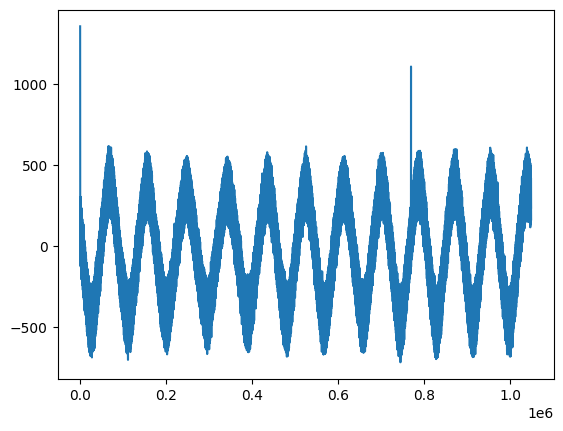

In [49]:
plt.plot(df.data)

In [50]:
def median_filter(data, window_size):
    """
    Простой медианный фильтр
    
    Parameters:
    data (array): исходный сигнал
    window_size (int): размер окна фильтра (нечетное число)
    
    Returns:
    array: отфильтрованный сигнал
    """
    if window_size % 2 == 0:
        raise ValueError("Размер окна должен быть нечетным числом")
    
    # Создаем копию данных для результата
    result = np.zeros_like(data)
    half_window = window_size // 2
    
    # Обрабатываем центральную часть сигнала
    for i in range(half_window, len(data) - half_window):
        window = data[i - half_window:i + half_window + 1]
        result[i] = np.median(window)
    
    # Обрабатываем края (просто копируем исходные значения)
    result[:half_window] = data[:half_window]
    result[-half_window:] = data[-half_window:]
    
    return result

In [ ]:
filtered_data = median_filter(df.data, window_size=11)

In [73]:
# Применяем медианный фильтр из scipy
window_size = 5
filtered_scipy = signal.medfilt(df.data, kernel_size=window_size)

In [74]:
%matplotlib qt5
plt.plot(df.data)
# plt.plot(filtered_data)
plt.plot(filtered_scipy)